In [1]:
!pip3 -q install sklearn pandas

import pandas as pd
import sklearn
print("pandas version {} installed".format(pd.__version__))
print("scikit-learn version {} installed".format(sklearn.__version__))

pandas version 0.19.2 installed
scikit-learn version 0.18.1 installed


In [2]:
# %load model_definition.py
"""Create Keras model"""

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm

def create_model(input_dim, output_dim):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(100, input_dim=input_dim, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # hidden layer
    model.add(Dense(60, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # output layer
    model.add(Dense(output_dim, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [3]:
# Import pandas 
import train_util as util
import plot_util as plots

helper = util.LendingClubModelHelper()

# Read in lending club data 
helper.read_csv("lc-2015-loans.csv", 
                util.APPLICANT_NUMERIC +
                util.APPLICANT_CATEGORICAL +
                util.CREDIT_NUMERIC +
                util.LABEL)


print(helper.lcdata.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 50 columns):
loan_amnt                     421095 non-null int64
term                          421095 non-null object
installment                   421095 non-null float64
grade                         421095 non-null object
emp_length                    421095 non-null object
home_ownership                421095 non-null object
annual_inc                    421095 non-null float64
addr_state                    421095 non-null object
dti                           421095 non-null float64
delinq_2yrs                   421095 non-null int64
fico_range_low                421095 non-null int64
fico_range_high               421095 non-null int64
open_acc                      421095 non-null int64
pub_rec                       421095 non-null int64
revol_bal                     421095 non-null int64
revol_util                    421095 non-null float64
total_acc                     421095 non-nul

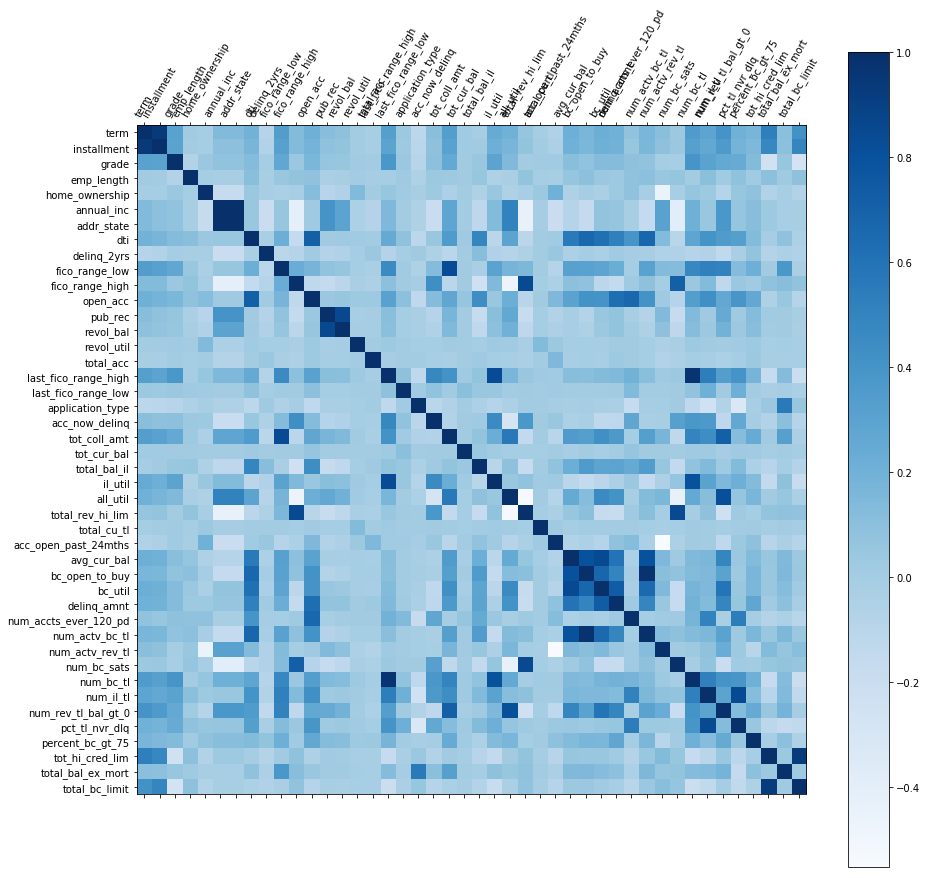

In [4]:
%matplotlib inline

# Show a correlation matrix of the features in our data set
plots.plot_correlation_matrix(helper.lcdata)

In [5]:
import os

# Divide the data set into training and test sets
helper.split_data(util.APPLICANT_NUMERIC + util.CREDIT_NUMERIC,
                  util.APPLICANT_CATEGORICAL,
                  util.LABEL,
                  test_size = 0.2,
                  row_limit = os.environ.get("sample"))

# Inspect our training data
print(helper.x_train.sample())

# Loan grade has been one-hot encoded
print(helper.y_train.sample())

Using only a sample of 50000 observations
        annual_inc       dti  age_earliest_cr  loan_amnt  installment  \
245509   -0.413869  0.315765         0.270317  -1.494547    -1.475912   

        acc_now_delinq  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  \
245509       -0.073673             -0.528056    -0.625333       -0.651966   

         bc_util     ...      TX  UT  VA  VT  WA  WI  WV  WY   36 months  \
245509  1.370959     ...       0   0   0   0   0   0   0   0           1   

         60 months  
245509           0  

[1 rows x 113 columns]
        grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G
177575        0        0        1        0        0        0        0


In [6]:
from model_definition import create_model

history = helper.train_model(create_model)

# list all data in history
print(history.history.keys())

Train on 32000 samples, validate on 8000 samples
Epoch 1/38
1s - loss: 1.3567 - acc: 0.4183 - val_loss: 1.1893 - val_acc: 0.4798
Epoch 2/38
1s - loss: 1.1733 - acc: 0.4880 - val_loss: 1.0292 - val_acc: 0.5667
Epoch 3/38
1s - loss: 1.0091 - acc: 0.5593 - val_loss: 0.8255 - val_acc: 0.6526
Epoch 4/38
1s - loss: 0.8625 - acc: 0.6248 - val_loss: 0.7063 - val_acc: 0.7021
Epoch 5/38
1s - loss: 0.7597 - acc: 0.6724 - val_loss: 0.5870 - val_acc: 0.7609
Epoch 6/38
1s - loss: 0.6775 - acc: 0.7074 - val_loss: 0.5128 - val_acc: 0.7991
Epoch 7/38
1s - loss: 0.6289 - acc: 0.7291 - val_loss: 0.4877 - val_acc: 0.8039
Epoch 8/38
1s - loss: 0.5849 - acc: 0.7487 - val_loss: 0.4564 - val_acc: 0.8150
Epoch 9/38
1s - loss: 0.5515 - acc: 0.7628 - val_loss: 0.4671 - val_acc: 0.8044
Epoch 10/38
1s - loss: 0.5274 - acc: 0.7751 - val_loss: 0.4216 - val_acc: 0.8250
Epoch 11/38
1s - loss: 0.5055 - acc: 0.7810 - val_loss: 0.4121 - val_acc: 0.8201
Epoch 12/38
1s - loss: 0.4928 - acc: 0.7874 - val_loss: 0.3922 - val_

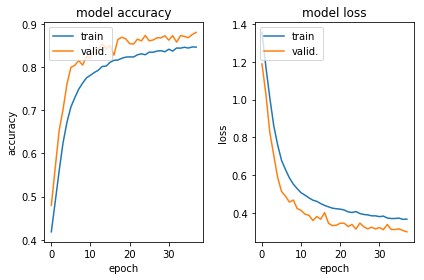

In [7]:
plots.plot_history(history)

Test Set Accuracy: 88%


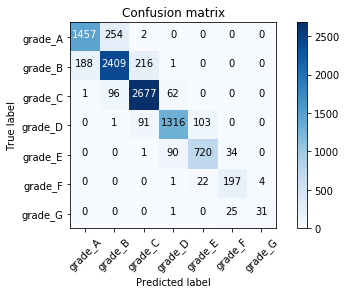

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

y_pred = helper.model.predict(helper.x_test.as_matrix())

# Revert one-hot encoding to classes
y_pred_classes = pd.DataFrame((y_pred.argmax(1)[:,None] == np.arange(y_pred.shape[1])),
                              columns=helper.y_test.columns,
                              index=helper.y_test.index)

y_test_vals = helper.y_test.idxmax(1)
y_pred_vals = y_pred_classes.idxmax(1)

# F1 score
# Use idxmax() to convert back from one-hot encoding
f1 = f1_score(y_test_vals, y_pred_vals, average='weighted')
print("Test Set Accuracy: {:.00%}".format(f1))

# Confusion matrix
cfn_matrix = confusion_matrix(y_test_vals, y_pred_vals)
plots.plot_confusion_matrix(cfn_matrix, classes=helper.y_test.columns)